# Gear box fault diagnosis - ANN model (PyTorch)

## Imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [2]:
df = pd.read_csv('Processed_data/processed_and_shuffled_df.csv')
#df = df.drop('Unnamed: 0',axis=1)
#df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df.head()

,Unnamed: 0,a1_freq_0,a1_freq_1,a1_freq_2,a1_freq_3,a1_freq_4,a1_freq_5,a1_freq_6,a1_freq_7,a1_freq_8,...,a4_freq_57,a4_freq_58,a4_freq_59,a4_freq_60,a4_freq_61,a4_freq_62,a4_freq_63,a4_freq_64,load,failure
0,0,0.005101,1.247122,0.478911,0.137187,0.416799,0.452218,0.648994,0.428732,1.025357,...,0.235110,1.070931,0.276280,0.662413,0.597808,0.308686,0.246427,0.208248,9.0,0.0
1,1,0.101887,1.300294,0.460277,0.508689,0.066402,0.143962,0.102928,0.252416,0.741350,...,0.239470,0.093433,0.587990,0.170224,0.251937,0.194196,0.091358,0.172850,6.0,0.0
2,2,0.114595,0.608045,1.544988,0.133156,0.399378,0.552593,0.395670,0.383603,0.169256,...,0.073918,0.184883,0.054254,0.379204,0.365445,0.113719,0.064615,0.119418,1.0,0.0
3,3,0.074220,0.706798,0.453239,0.093307,0.521446,0.532933,0.570955,0.428299,0.440809,...,0.356629,0.291972,0.537028,0.367629,0.229246,0.136271,0.173111,0.175452,2.0,1.0
4,4,0.169813,0.532547,0.877946,0.620596,0.767804,0.900650,0.397537,1.248088,1.579174,...,0.235135,0.311891,0.202014,0.393056,0.180624,0.110899,0.046682,0.126975,8.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789 entries, 0 to 15788
Columns: 263 entries, Unnamed: 0 to failure
dtypes: float64(262), int64(1)
memory usage: 31.7 MB


In [5]:
#df.corr()

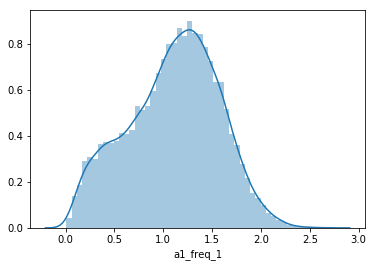

In [6]:
#sns.kdeplot(data = df, x='a1_freq_1')
#sns.distplot(data=df,x='a1_freq_1'))
#df['a1_freq_0'].mean()
sns.distplot(df['a1_freq_1'],)

## Separate categorical from continuous columns

In [7]:
df.columns

Index(['Unnamed: 0', 'a1_freq_0', 'a1_freq_1', 'a1_freq_2', 'a1_freq_3',
       'a1_freq_4', 'a1_freq_5', 'a1_freq_6', 'a1_freq_7', 'a1_freq_8',
       ...
       'a4_freq_57', 'a4_freq_58', 'a4_freq_59', 'a4_freq_60', 'a4_freq_61',
       'a4_freq_62', 'a4_freq_63', 'a4_freq_64', 'load', 'failure'],
      dtype='object', length=263)

In [8]:
cat_cols = ['load']
cont_cols = df.columns[0:-2]
y_col = ['failure']  # this column contains the labels

In [9]:
# Convert categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [10]:
df['load'].cat.categories

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')

In [11]:
#categories to numpy array
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [12]:
cats[:10]

array([[9],
       [6],
       [1],
       [2],
       [8],
       [7],
       [2],
       [8],
       [7],
       [6]], dtype=int8)

## Numpy arrays to Tensors

In [13]:
# converting categorical values to tensor
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[9],
        [6],
        [1],
        [2],
        [8]])

In [14]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float32)
conts[:5]

tensor([[0.0000, 0.0051, 1.2471,  ..., 0.3087, 0.2464, 0.2082],
        [1.0000, 0.1019, 1.3003,  ..., 0.1942, 0.0914, 0.1729],
        [2.0000, 0.1146, 0.6080,  ..., 0.1137, 0.0646, 0.1194],
        [3.0000, 0.0742, 0.7068,  ..., 0.1363, 0.1731, 0.1755],
        [4.0000, 0.1698, 0.5325,  ..., 0.1109, 0.0467, 0.1270]])

In [15]:
conts.shape

torch.Size([15789, 261])

In [16]:
conts.type()

'torch.FloatTensor'

In [17]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values,dtype=torch.long).flatten()

y[:5]

tensor([0, 0, 0, 1, 1])

In [18]:
y.shape

torch.Size([15789])

## Embeddings

In [19]:
# This will set embedding sizes 'load'
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(10, 5)]

## Tabular model

In [20]:
class TabularModel(nn.Module):
    
    # emb_szs - embeding sizes
    # n_count - number of continous features
    # out_sz - output size
    # layers - list of layers
    # p - probability for dropouts
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.5):
        
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
        
    
    def forward(self, x_cat, x_cont):
        
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        
        return x
    

In [21]:
torch.manual_seed(17)
model = TabularModel(emb_szs, conts.shape[1], 2, [16,8], p=0.4) # out_sz = 2

In [22]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 5)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(261, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=266, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=8, out_features=2, bias=True)
  )
)

## Define loss function & optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train/test splits

In [24]:
batch_size = 15789
test_size = 5000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [25]:
type(y_train)

torch.Tensor

## Train the model

In [26]:
import time
start_time = time.time()

epochs = 100
losses = []
test_losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        
        
    with torch.no_grad():
        y_val = model(cat_test, con_test)
        test_loss = criterion(y_val, y_test)
        test_losses.append(test_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 1.13519681
epoch:  11  loss: 0.41477963
epoch:  21  loss: 0.30737135
epoch:  31  loss: 0.25375259
epoch:  41  loss: 0.20538667
epoch:  51  loss: 0.16813219
epoch:  61  loss: 0.14577362
epoch:  71  loss: 0.12739919
epoch:  81  loss: 0.11119463
epoch:  91  loss: 0.10189959
epoch: 100  loss: 0.09211235

Duration: 10 seconds


In [27]:
#save model
torch.save(model.state_dict(), 'gearbox_fault_diagnosis.pt')

## Plot the loss function

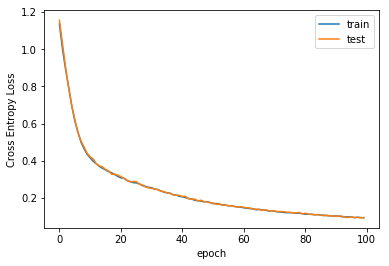

In [28]:
plt.plot(range(epochs), losses,label='train')
plt.plot(range(epochs), test_losses,label='test')
plt.legend()
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Validation

In [29]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.09087569


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
y_pred = []

for i in range(0,len(y_val)):
    y_pred.append(y_val[i].argmax().item())

In [32]:
confusion_matrix(y_test,y_pred)

array([[2512,    9],
       [  26, 2453]])

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2521
           1       1.00      0.99      0.99      2479

   micro avg       0.99      0.99      0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

